# 第7章　アンサンブル学習とランダムフォレスト

アンサンブル→一群の学習器をまとめること  
例ランダムフォレスト  
バギング，ブースティング，スタッキングについても触れる7.
## 7.1 投票分類器

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#moons data import
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
#three classifiers の投票分類器
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
                estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
                voting="hard")
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [6]:
from sklearn.metrics import accuracy_score

for clf in [log_clf, rnd_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


`voting = "soft"` vs `voting = "hard"`  
個々の確率が計算できる場合，最も高い確率のクラスに所属することをsoft votingという

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True,random_state=42)

voting_clf = VotingClassifier(
                estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
                voting="soft")
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in [log_clf, rnd_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## 7.2 バギングとペースティング
多様性の高い分類器作成の方法→大きく異なる訓練アルゴリズムを持つ学習器たちを利用する  
他のアプローチ  
訓練セットから無作為に別のサブセットを抽出する方法.   
重複あり→**バギング**，重複無し→**ペースティング**

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                           n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [16]:
#bagging とtreeの決定境界の図示
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap= custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

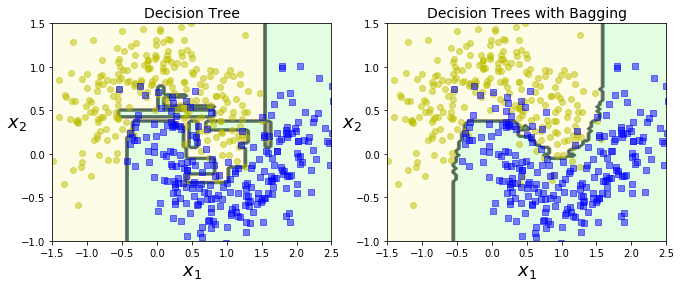

In [18]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

In [21]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(random_state=42), n_estimators=500,
            bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

## 7.4 ランダムフォレスト

In [22]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

```bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
```  
とほぼ一緒  
ランダムフォレストのメリット  
→各特徴量の相対的な重要度を容易に知ることができること

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10067415192873304
sepal width (cm) 0.020221683667390012
petal length (cm) 0.4501005330595443
petal width (cm) 0.4290036313443325


In [27]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [30]:
rnd_clf=RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
import matplotlib
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

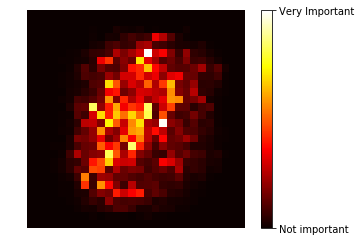

In [36]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very Important"])
plt.show()

## 7.5 ブースティング
アダブースト→分類に失敗した訓練インスタンスの相対的な重みをあげて新しい分類器を作成

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

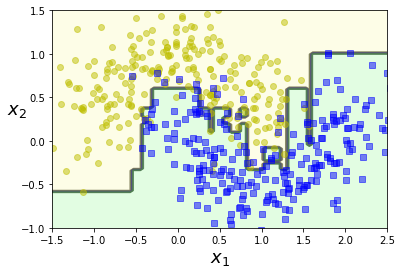

In [38]:
plot_decision_boundary(ada_clf, X, y)

勾配ブースティング→新予測機を前の予測機の残差に適合させようとする

In [50]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [52]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [53]:
y3 = y - tree_reg1.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [54]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [55]:
y_pred

array([0.60839441])

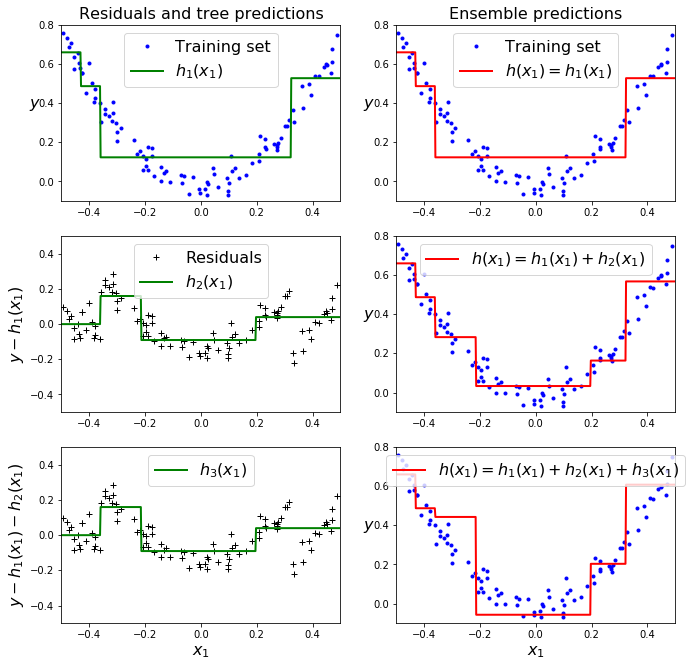

In [56]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)


plt.show()

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

In [61]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

In [63]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=52, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
bst_n_estimators

52

## 7.7 演習問題
>1. 全く同じ訓練データを使って5個の異なるモデルを訓練し，それらがすべて95%の適合率を達成した時，それらのモデルを組み合わせたら，もっと良い結果が得られる可能性はあるか．もしそうだとすれば，どのようにして良い結果が得られるのか．そうでないとすればそれはなぜか


もっと良い結果が得られる可能性がある．  
理由：あるモデルが間違った分類をしたとしても，残りの4つが正しい分類をしていれば正しく分類されるから．

> 2. ハード投票器とソフト投票器の違いは何か

確率値の平均を取り，最も確率が高いクラスを予想クラスとするものがソフト  
単純な多数決がハード

> 3. 複数のサーバで分散処理することでバギングアンサンブルのスピードを上げることができるか．ペースティングアンサンブル，ブースティングアンサンブル，ランダムフォレスト，スタッキングアンサンブルではどうか

バギング→訓練セットを無作為に抽出し学習させる．訓練セットのサンプリングは重複あり  
ペースティング→バギングの訓練セットサンプリング重複無しパターン  
ブースティング→逐次的に学習器を訓練し，その結果を利用して良い学習器を作る  
ランダムフォレスト→決定木をいっぱい作り，多数決  
スタッキング→異なる予測器に訓練セットを入れ，得た結果を用いて次の予測器層を訓練

分散処理できる→バギング，ペースティング，ランダムフォレスト  
分散処理できない→ブースティング，スタッキング

> 4. OOB検証の長所は何か

その訓練データが使われなかった学習器の集合に対して，その訓練データで検証することで汎化性能を確認できる点

> 5. Extra-Trees分類器が通常のランダムフォレストより無作為的なのは何によるものか．この余分に無作為的なことにはどのような意味があるか．Extra-Treeは通常のランダムフォレストと比べて遅いか，それとも早いか

ランダムフォレスト→無作為に取り出したデータセットだけでここのノードの分割を判断  
Extra-Tree→サブセット無作為に加え，無作為な閾値を利用．よって短時間で訓練可能  

> 6. アダブーストアンサンブルが訓練に過少適合している時，どのハイパーパラメータをどのように操作するべきか

sklearn.ensanble.AdaBoostClassifier()のハイパーパラメータ  
* (base_estimator)
* n_estimators
* learning_rate
* algorithm  
→学習率を上げる，n_estimatorsを増やす．base_estimatorの正則化パラを下げる(過学習を促進)

> 7. 勾配ブースティングアンサンブルが訓練セットに過学習している場合学習率を上げるべきか，下げるべきか

下げるべき

> 8. mnistデータをロードし，それらを訓練セット・検証セット・テストセットに分割し， RandomForest, Extra-Trees, SVMなどさまざまな分類器を訓練しよう

In [115]:
mnist['target'] = np.array(list(map(lambda x:int(x), mnist['target'])))

In [116]:
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist['data'], mnist['target'], test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rnd_forest_clf = RandomForestClassifier(random_state=42)
extra_tree_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [rnd_forest_clf, extra_tree_clf, svm_clf, mlp_clf]
for estimator in estimators:
    estimator.fit(X_train, y_train)

In [118]:
from sklearn.metrics import accuracy_score
for estimator in estimators:
    y_val_pred = estimator.predict(X_val)
    print(estimator.__class__.__name__, '\t', accuracy_score(y_val, y_val_pred))

RandomForestClassifier 	 0.9469
ExtraTreesClassifier 	 0.9492
LinearSVC 	 0.8641
MLPClassifier 	 0.9648


In [119]:
from sklearn.ensemble import VotingClassifier

named_estimators = [("ramdon_forest_clf", rnd_forest_clf),
                    ("extra_trees_clf", extra_tree_clf),
                    ("svm_clf", svm_clf),
                    ("mlp_clf", mlp_clf)]

voting_clf_hard = VotingClassifier(named_estimators, voting='hard', n_jobs=-1)
voting_clf_soft = VotingClassifier(named_estimators, voting='soft', n_jobs=-1)

In [78]:
voting_clf_hard.fit(X_train, y_train)
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('ramdon_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [120]:
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

voting_clf.score(X_val, y_val)

0.9625

In [121]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9469, 0.9492, 0.8641, 0.9648]

In [122]:
voting_clf.voting = 'soft'
del voting_clf.estimators_[2]

voting_clf.score(X_val, y_val)

0.9689

In [123]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9469, 0.9492, 0.9648]

> 9.検証セットを対象として，前問の個別の分類器で予測を行い，その予測結果から新しい訓練セットを作りなさい．その訓練セットの個々のインスタンスは，イメージに対して全ての予測器が返した予測をまとめたベクトルで，ターゲットはイメージのクラスである．

In [140]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
                             

In [141]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [142]:
rnd_forest_blender.oob_score_

0.9627

In [143]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [144]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [145]:
accuracy_score(y_test, y_pred)

0.9625